# **Exucute Query using the NEIVA Database**

###**1. Create a `mysql` server in the Colab environment.**


In [ ]:
!pip install mysql-connector-python # Install the necessary package to connect Python with MySQL databases.
!apt-get -y install mysql-server    # Install the MySQL server on the Colab environment.
!service mysql start                # With MySQL install, this starts the server.

# Setting the password. Here 'root' is used as password.

!mysql -e "ALTER USER 'root'@'localhost' IDENTIFIED WITH 'mysql_native_password' BY 'root';FLUSH PRIVILEGES;"

### **2. Create the NEIVA database in the `mysql` server.**

In [ ]:
# Upload the database files. This will provide a 'upload' button. Upload all the database (.sql) files.
# Note: For best results, use google chrome to run the notebook.
from google.colab import files
uploaded = files.upload()

In [52]:
# Check if the sql files are uploaded.
!ls *.sql


backend_db.sql	legacy_db.sql  neiva_output_db.sql  primary_db.sql  raw_db.sql


In [ ]:
# Load the database files into the mysql server. (Note: Do not change the database names).
!mysql -u root -proot backend_db < backend_db.sql
!mysql -u root -proot legacy_db < legacy_db.sql
!mysql -u root -proot neiva_output_db < neiva_output_db.sql
!mysql -u root -proot primary_db < primary_db.sql
!mysql -u root -proot raw_db < raw_db.sql

In [2]:
# Check if the databases are available in the mysql server.
!mysql -u root -proot -e "show databases"

mysql: [Warning] Using a password on the command line interface can be insecure.
+--------------------+
| Database           |
+--------------------+
| backend_db         |
| information_schema |
| legacy_db          |
| mysql              |
| neiva_output_db    |
| performance_schema |
| primary_db         |
| raw_db             |
| sys                |
+--------------------+


In [3]:
# Querying the tables of a database.
!mysql -u root -proot -e "use neiva_output_db; show tables;"

mysql: [Warning] Using a password on the command line interface can be insecure.
+---------------------------+
| Tables_in_neiva_output_db |
+---------------------------+
| Integrated_EF             |
| Processed_EF              |
| Property_Surrogate        |
| Recommended_EF            |
| property                  |
+---------------------------+


In [22]:
# Establishing connection with MySQL database
import mysql.connector

def connect_db(db):
  con = mysql.connector.connect(user='root', password='root', host='localhost', database=db)
  return con

legacy_db=connect_db('legacy_db')
raw_db=connect_db('raw_db')
primary_db=connect_db('primary_db')
output_db=connect_db('neiva_output_db')
bk_db=connect_db('backend_db')

###**3. Define query functions**

In [74]:
import pandas as pd
import numpy as np
!pip install pubchempy
import pubchempy as pcp
import matplotlib.pyplot as plt

# This function returns the PM2.5, OC, BC data for a specified fire type and table name. The table name inlcudes three different tables
# integrated ef, processed ef, recommended ef.
def select_pm_data (ft, table_name):

    if table_name=='integrated ef':
        efcoldf=pd.read_sql('select * from bkdb_info_efcol', con=bk_db)
        df=pd.read_sql('select * from Integrated_EF', con=output_db)

        efcol=list(efcoldf['efcol'])
        efcoldf['BC']=df[efcol][df['id']=='BC'].values[0]
        efcoldf['OC']=df[efcol][df['id']=='OC'].values[0]
        efcoldf['PM2.5']=df[efcol][df['id']=='PM2.5'].values[0]
        efcoldf['OA']=df[efcol][df['id']=='OC'].values[0]

        return (efcoldf[['legend','MCE','PM2.5','OC','BC','OA']][efcoldf['fire_type']==ft])

    if table_name=='processed ef':
        efcoldf=pd.read_sql('select * from info_efcol_processed_data', con=bk_db)
        df=pd.read_sql('select * from Processed_EF', con=output_db)

        efcol=list(efcoldf['efcol'])
        efcoldf['BC']=df[efcol][df['id']=='BC'].values[0]
        efcoldf['OC']=df[efcol][df['id']=='OC'].values[0]
        efcoldf['PM2.5']=df[efcol][df['id']=='PM2.5'].values[0]
        efcoldf['OA']=df[efcol][df['id']=='OC'].values[0]

        return (efcoldf[['legend','PM2.5','OC','BC','OA']][efcoldf['fire_type']==ft])

    if table_name=='recommended ef':
        df=pd.read_sql('select * from Recommended_EF', con=output_db)
        efcol='AVG_'+ft.replace(' ','_')
        iid=['PM<2.5','OC','BC','OA']
        return df[['compound',efcol]][df['id'].isin(iid)]

# This function returns the list of pollutant category of recommended ef dataset.
def display_pollutant_category():
    rdf=pd.read_sql('select * from Recommended_EF', con=output_db)
    ll=rdf['pollutant_category'].unique()
    return list(ll)

# This function returns the EF of specified pollutant category and fire type.
def select_ef_pollutant_category(ft, pc):
    efcol='AVG_'+ft.replace(' ','_')
    rdf=pd.read_sql('select * from Recommended_EF', con=output_db)

    if pc=='PM optical property':
      return (rdf[['compound',efcol]][rdf['pollutant_category']==pc][rdf[efcol].notna()])
    else:
      return (rdf[['mm','formula','compound',efcol]][rdf['pollutant_category']==pc][rdf[efcol].notna()])

# This function returns the EF of specified compound name and table name (integrated ef, processed ef and recommended ef)
def select_compound(ft, com_name,table_name):
    if table_name=='integrated ef':
        df=pd.read_sql('select * from Integrated_EF', con=output_db)
        efcoldf=pd.read_sql('select * from bkdb_info_efcol', con=bk_db)
        allcol= ['legend','fuel_type','measurement_type','MCE',com_name]

    if table_name=='processed ef':
        df=pd.read_sql('select * from Processed_EF', con=output_db)
        efcoldf=pd.read_sql('select * from info_efcol_processed_data', con=bk_db)
        allcol= ['legend','measurement_type',com_name]

    aa=pcp.get_compounds(com_name, 'name')[0].inchi
    ind=df[df['id']==aa].index[0]

    efcol=list(efcoldf['efcol'])

    efcoldf[com_name]=df[efcol].iloc[ind].values

    ll=efcoldf[allcol][efcoldf['fire_type']==ft]
    ll=ll.sort_values(by='measurement_type')
    ll=ll[ll[com_name].notna()]
    ll=ll.reset_index(drop=True)
    return ll

 # This funtion returns the model surrogates of a specified chemical mechanism
 # S07, S07T, S18B, S22, MOZT1
def model_surrogates(chem):
  pp=pd.read_sql('select * from property', con=output_db)
  return pp[chem].unique()

# This function returns the speciation compounds of specified chemical mechanism and model surrogate
def speciation_profile(ft,chem,spc):
  pp=pd.read_sql('select * from Property_Surrogate', con=output_db)
  df=pd.read_sql('select * from Recommended_EF', con=output_db)
  df=df.merge(pp[pp.columns[3:]],on='id', how='left')
  efcol='AVG_'+ft.replace(' ','_')
  return df[['formula','compound',efcol,chem]][df[chem]==spc][df[efcol].notna()]

# Plots ef data of a specified fire type and table name
def plot_ef(compound,ft, table_name):
  if table_name=='processed ef':
    df=pd.read_sql('select * from Processed_EF', con=output_db)
    efcoldf=pd.read_sql('select * from info_efcol_processed_data', con=bk_db)

  if table_name=='integrated ef':
    df=pd.read_sql('select * from Integrated_EF', con=output_db)
    efcoldf=pd.read_sql('select * from bkdb_info_efcol', con=bk_db)

  iid=pcp.get_compounds(compound, 'name')[0].inchi
  ind=df[df['id']==iid].index[0]

  efcoldf[compound]=df[efcoldf['efcol']].iloc[ind].values

  ef_vals=list(efcoldf[compound][efcoldf['fire_type']==ft][efcoldf[compound].notna()])
  l1=efcoldf['study'][efcoldf['fire_type']==ft][efcoldf[compound].notna()]
  l2=efcoldf['fuel_type'][efcoldf['fire_type']==ft][efcoldf[compound].notna()]
  if table_name=='processed ef':
    ef_legend=list(l1)
  if table_name=='integrated ef':
    ef_legend=list(l1+':'+l2)

  ax = plt.subplot(111)
  plt.scatter(np.arange(len(ef_vals)), ef_vals)
  plt.ylabel('Emission factor (g/kg)')
  plt.title("Compound:"+compound+"; Fire type:"+ ft)
  plt.xticks(np.arange(len(ef_vals)), ef_legend, rotation=90)
  plt.grid(alpha=0.2)
  plt.tight_layout()
  return

###**4. Execute Query using the defined functions**

**Example 1: Querying the PM 2.5, OC, BC data of a specific fire type**

In [70]:
select_pm_data ('savanna', 'recommended ef')

,compound,AVG_savanna
1125,PM<2.5,12.8867
1126,OC,6.4867
1129,Organic Aerosol (OA),27.3400
1134,BC,0.3700


In [71]:
select_pm_data ('savanna', 'integrated ef')

,legend,MCE,PM2.5,OC,BC,OA
31,Akagi_11(Stockwell et al 15),0.977,NaN,NaN,NaN,NaN
32,Akagi_11(Christian et al 03),NaN,NaN,NaN,NaN,NaN
33,Akagi_11(Yokelson et al 03),0.938,NaN,NaN,NaN,NaN
34,Akagi_11(Sinha et al 03),0.941,NaN,2.30,0.39,2.30
35,Akagi_11(Ferek et al 98),0.962,NaN,2.94,0.35,2.94
36,Akagi_11(Yokelson et al 11),0.930,NaN,NaN,NaN,NaN
37,Akagi_11(Christian et al 03),0.953,NaN,NaN,NaN,NaN
123,Jayarathne et al 14,0.979,2.3,NaN,NaN,NaN
173,Pokhrel et al 16,NaN,NaN,NaN,NaN,NaN
174,Pokhrel et al 16,NaN,NaN,NaN,NaN,NaN


**Example 2: Querying the Recommended EF table for a specific pollutant category**

In [28]:
display_pollutant_category()

['inorganic gas',
 'methane',
 'NMOC_g',
 'PM total',
 'PM carbon',
 'PM ion',
 'PM metal',
 'NMOC_p:polycyclic aromatic hc',
 'NMOC_p:hopane',
 'NMOC_p:n alkane',
 'NMOC_p:anhydrosugar',
 'NMOC_p:lignin decomposition product',
 'NMOC_p:sterol stanol',
 'NMOC_p:tricyclic terpane',
 'PM optical property']

In [29]:
select_ef_pollutant_category('peat', 'NMOC_p:n alkane')

,mm,formula,compound,AVG_peat
1219,268.50,C19H40,Pristane,0.0124
1220,254.50,C18H38,Norpristane,0.0043
1222,422.80,C30H62,Squalane,0.0162
1223,254.50,C18H38,Octadecane,0.0048
1224,268.50,C19H40,Nonadecane,0.0136
1225,282.50,C20H42,Eicosane,0.0273
1226,296.60,C21H44,Heneicosane,0.0471
1227,310.60,C22H46,Docosane,0.0533
1228,324.60,C23H48,Tricosane,0.0595
1229,338.70,C24H50,Tetracosane,0.0508


In [75]:
select_ef_pollutant_category('peat', 'PM optical property')

,compound,AVG_peat
1269,EF B abs 870 (m2 kg 1),0.0192
1270,EF B scat 870 (m 2 kg 1),10.7208
1271,EF Babs 405 (m2 kg1),1.3500
1272,EF B 405 (m2 kg1scat ),50.6000
1273,EF Babs 405 just BrC (m2 kg1),1.3000
1274,EF Babs 405 just BC (m2 kg1),0.0540
1275,SSA 870 nm,0.9970
1276,SSA 405 nm,0.9480
1277,AAE,6.3255
1278,SSA 532,0.9913


**Example 3: Qyerying the NMOC_g data from the Integrated EF dataset**

In [31]:
select_compound('boreal forest', 'phenol','integrated ef')

,legend,fuel_type,measurement_type,MCE,phenol
0,Hayden et al 22,None,field,0.891,0.1200
1,Akagi_11(Bertschi et al 03),boreal organic soil,lab,0.866,3.2000
2,Akagi_11(Yokelson et al 97),boreal organic soil,lab,0.835,2.3400
3,Akagi_11(Bertschi et al 03),woody,lab,0.882,3.4000
4,Akagi_11(Yokelson et al 97),boreal peat,lab,0.809,7.9900
5,Hatch et al 15,black spruce,lab,0.937,0.1251
6,Stockwell et al 15,black spruce,lab,0.959,0.1954


**Example 4: Querying NMOC_g data from Processed EF dataset**

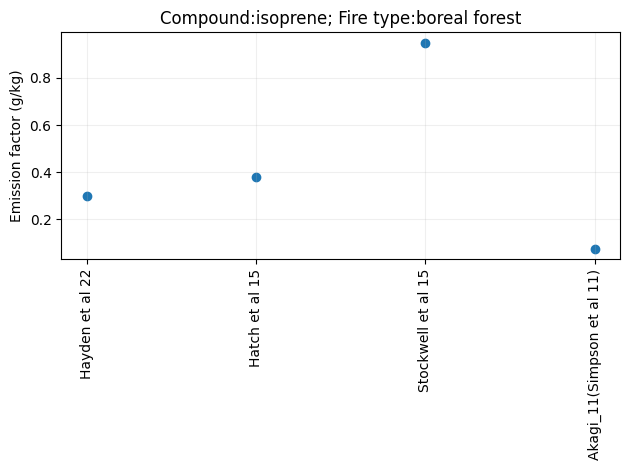

In [55]:
plot_ef('isoprene','boreal forest', 'processed ef' )

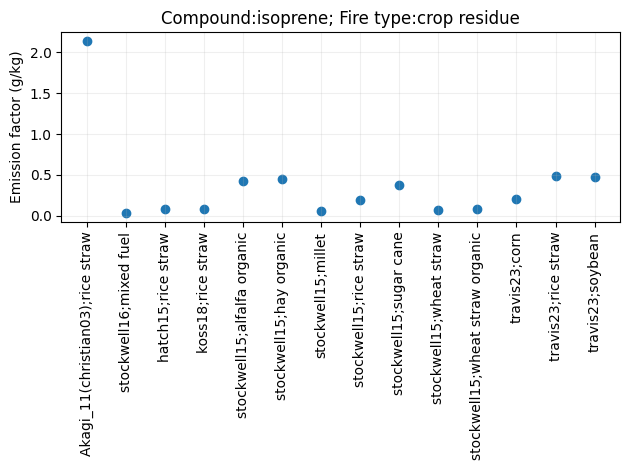

In [66]:
plot_ef('isoprene','crop residue', 'integrated ef' )

**Example 5: Querying speciation of the model surrogates**

In [36]:
model_surrogates('S07')

array(['ACYE', 'NROG', 'ETHE', 'HCHO', 'ALK1', 'MEOH', 'OLE1', 'ALK3',
       'CCHO', 'ALK2', 'ALK5', 'FACD', 'OLE2', 'MACR', 'GLY', 'RCHO',
       'ACET', 'AACD', 'ALK4', 'ARO2', 'ISOP', 'PACD', 'IPRD', 'MVK',
       'MGLY', 'MEK', 'RNO3', 'BENZ', 'ARO1', 'BACL', 'PRD2', 'CRES',
       'BALD', 'TERP', 'AFG3', None], dtype=object)

In [39]:
speciation_profile('savanna','S07','ARO2')

,formula,compound,AVG_savanna,S07
111,C4H4O,Furan,0.335100,ARO2
213,C5H6O,3-methylfuran,0.012000,ARO2
214,C5H6O,2-methylfuran,0.229600,ARO2
336,C6H8O,"2,5-dimethylfuran",0.273800,ARO2
453,C8H10,P-xylene,0.001492,ARO2
454,C8H10,M-xylene,0.005398,ARO2
455,C8H10,O-xylene,0.012909,ARO2
599,C9H12,3-ethyltoluene,0.011238,ARO2
600,C9H12,4-ethyltoluene,0.006743,ARO2
601,C9H12,2-ethyltoluene,0.006743,ARO2
